In [1]:
import pandas as pd
import json
import numpy as np
import operator
import matplotlib.pyplot as plt
from collections import Counter
import os
import time
import pickle
import networkx as nx
import string
import matplotsoccer
pd.options.mode.chained_assignment = None  # default='warn'



zone_positions = {
    'R0': (100/6, 250/3*0.68),
    'R1': (100/6, 50 *0.68),
    'R2': (100/6, 50/3 *0.68),
    'R3': (50, 250/3 *0.68),
    'R4': (50, 50 *0.68),
    'R5': (50, 50/3 *0.68),
    'R6': (250/3, 250/3 *0.68),
    'R7': (250/3, 50 *0.68),
    'R8': (250/3, 50/3 *0.68),
}

ROOT = os.path.dirname(os.getcwd())
teams = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'teams.pkl.gz'))
players = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'players.pkl.gz'))
players['shortName'] = players['shortName'].apply(lambda s: ''.join([x for x in s if x.isalpha() or x in [' ', '.'] ]))
player_mapping = {row['wyId'] : row['shortName'] for i, row in players.iterrows()}

# Approach
First lets get the zonal information for the passes from last time

In [71]:
zonal_info_passing = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'zonal_info_combined.pkl.gz'))
events = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'events_df.pkl.gz'))
matches = zonal_info_passing.index.get_level_values(0).unique()
zonal_info_passing

eventId subEventName                          tags  playerId  \
        teamId                                                                 
2499719 1609          8  Simple pass                [{'id': 1801}]     25413   
        1609          8  Simple pass                [{'id': 1802}]      7868   
        1609          8  Simple pass                [{'id': 1802}]      7945   
        1609          8  Simple pass                [{'id': 1801}]     49876   
        1609          8  Simple pass                [{'id': 1801}]     14869   
...                 ...          ...                           ...       ...   
2576338 3193          8  Simple pass  [{'id': 1401}, {'id': 1801}]    206318   
        3193          8  Simple pass                [{'id': 1801}]    345740   
        3193          8  Simple pass                [{'id': 1801}]     21468   
        3193          8    Head pass                [{'id': 1802}]    413041   
        3193          8  Simple pass                [{'id': 1802}]    345740   

                matchId eventName matchPeriod     eventSec subEventId  \
        teamId                                                          
2499719 1609    2499719      Pass          1H     2.758649         85   
        1609    2499719      Pass          2H   363.703116         85   
        1609    2499719      Pass          2H   393.577800         85   
        1609    2499719      Pass          2H   399.722259         85   
        1609    2499719      Pass          2H   400.916375         85   
...                 ...       ...         ...          ...        ...   
2576338 3193    2576338      Pass          2H     6.489681         85   
        3193    2576338      Pass          2H    12.714039         85   
        3193    2576338      Pass          2H    15.327703         85   
        3193    2576338      Pass          1H  2654.748427         82   
        3193    2576338      Pass          2H  2812.814903         85   

                       id         time  \
        teamId                           
2499719 1609    177959171     2.758649   
        1609    177960234  3216.260497   
        1609    177960245  3246.135181   
        1609    177960248  3252.279640   
        1609    177960249  3253.473756   
...                   ...          ...   
2576338 3193    253566109  2881.566065   
        3193    253566114  2887.790423   
        3193    253566115  2890.404087   
        3193    253566040  2654.748427   
        3193    253567149  5687.891287   

                                             pass_origin  \
        teamId                                             
2499719 1609                 [51.449999999999996, 33.32]   
        1609                               [91.35, 10.2]   
        1609                               [78.75, 4.08]   
        1609                               [65.1, 25.84]   
        1609                 [58.800000000000004, 14.96]   
...                                                  ...   
2576338 3193                               [31.5, 59.84]   
        3193                 [29.400000000000002, 65.96]   
        3193                  [12.6, 37.400000000000006]   
        3193    [55.650000000000006, 3.4000000000000004]   
        3193                  [70.35000000000001, 48.28]   

                                       pass_destination  zone_origin  \
        teamId                                                         
2499719 1609                             [32.55, 53.04]          4.0   
        1609    [87.14999999999999, 3.4000000000000004]          8.0   
        1609                               [73.5, 2.04]          8.0   
        1609                [58.800000000000004, 14.96]          4.0   
        1609     [57.75000000000001, 6.800000000000001]          5.0   
...                                                 ...          ...   
2576338 3193                [40.95, 63.919999999999995]          0.0   
        3193                 [12.6, 37.4000000000

In [212]:
matchId = 2499719

#Get the time for the latest event in the first half for this match
end_first_half = events.loc[(events['matchId']==matchId)
                            &(events['matchPeriod']=='1H'), ['eventSec']].max().values[0]


df = zonal_info_passing.loc[(zonal_info_passing.index.get_level_values(0)==matchId)]
df.loc[:, 'time'] = (df['matchPeriod']=='2H')*end_first_half + df['eventSec']
df['teamId'] = df.index.get_level_values(1)
#df = df[['playerId', 'positions', 'teamId', 'time']]


team1, team2 = df['teamId'].unique()
profile_team1 = df.loc[df['teamId'] == team1, :].sort_values(by='time').reset_index(drop=True)
profile_team2 = df.loc[df['teamId'] == team2, :].sort_values(by='time').reset_index(drop=True)



#Formatting these for the graphs
profile_team1 = profile_team1[['zone_origin', 'zone_destination']]
profile_team1 = profile_team1.loc[profile_team1['zone_origin'] != profile_team1['zone_destination']]
profile_team1 = profile_team1.groupby(['zone_origin','zone_destination']).size().to_frame('weight').reset_index().astype(int)

profile_team2 = profile_team2[['zone_origin', 'zone_destination']]
profile_team2 = profile_team2.loc[profile_team2['zone_origin'] != profile_team2['zone_destination']]
profile_team2 = profile_team2.groupby(['zone_origin','zone_destination']).size().to_frame('weight').reset_index().astype(int)

### Graph Visualization

Arsenal
centrality = 0.0
density = 0.7083333333333334


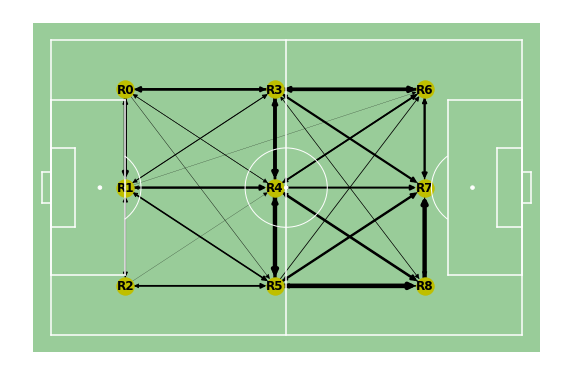

Arsenal: mean = 1.9607843137254901 ; std = 1.5266800122048088 ; count = 402



 Leicester City
centrality = 0.0
density = 0.5972222222222222


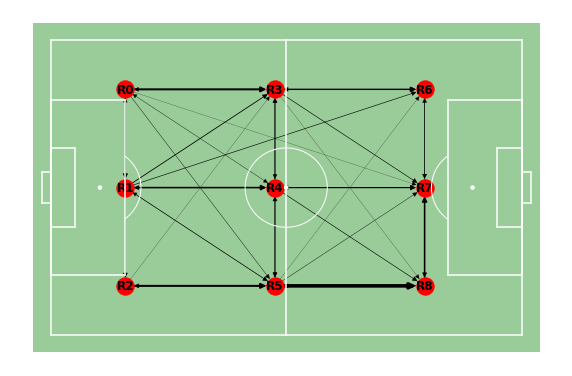

Arsenal: mean = 2.3255813953488373 ; std = 2.3746158364347267 ; count = 140


In [213]:
team1, team2 = teams.loc[teams['wyId']==team1,'name'].values[0], teams.loc[teams['wyId']==team2,'name'].values[0]

#team1
ax = matplotsoccer.field("green",figsize=10, show=False)
g = nx.DiGraph()
g.add_edges_from([(row['zone_origin'], row['zone_destination'], {'weight':row['weight']}) for i, row in profile_team1.iterrows()])
g = nx.relabel_nodes(g, {i: 'R{}'.format(i) for i in range(9)})
nx.draw(g, zone_positions, with_labels=True, font_weight='bold', node_color = 'y', 
        width=[g[u][v]['weight']/5 for u, v in g.edges()], ax=ax)
print (team1)
print ('centrality =', nx.global_reaching_centrality(g))
print ('density =', nx.density(g))
plt.savefig(os.path.join(ROOT, 'figures', 'passing_lane_study_nov_13', 'zone_graph_ex1.png'))
plt.show()
print ('%s: mean ='%team1, profile_team1['weight'].mean()/profile_team1['weight'].sum()*100,
       '; std =', profile_team1['weight'].std()/profile_team1['weight'].sum()*100,
       '; count =', profile_team1['weight'].sum())

#team2
ax = matplotsoccer.field("green",figsize=10, show=False)
g = nx.DiGraph()
g.add_edges_from([(row['zone_origin'], row['zone_destination'], {'weight':row['weight']}) for i, row in profile_team2.iterrows()])
g = nx.relabel_nodes(g, {i: 'R{}'.format(i) for i in range(9)})
nx.draw(g, zone_positions, with_labels=True, font_weight='bold', node_color = 'r',
        width=[g[u][v]['weight']/5 for u, v in g.edges()], ax=ax)
print ('\n\n\n', team2)
print ('centrality =', nx.global_reaching_centrality(g))
plt.savefig(os.path.join(ROOT, 'figures', 'passing_lane_study_nov_13', 'zone_graph_ex2.png'))
print ('density =', nx.density(g))
plt.show()
print ('%s: mean ='%team1, profile_team2['weight'].mean()/profile_team2['weight'].sum()*100,
       '; std =', profile_team2['weight'].std()/profile_team2['weight'].sum()*100,
       '; count =', profile_team2['weight'].sum())

## What metrics can we derive from these?

### 1) Zonal Mean & Std()
A high std() will imply the coexistence of "hot" zones and "cold" zones on the pitch. A lower std() will imply a more uniform distribution of passes across the pitch

In [166]:
p = pd.Series(dict(g.degree(weight='weight')))
display(p.mean())
display(p.std())

31.11111111111111

10.178954323068313

#### To Streamline

In [170]:
n = len(matches)
network_stats = dict()

for i, matchId in enumerate(matches):
    if i % 50 == 0: print('{}/{}'.format(i, n))
        
    #Get the time for the latest event in the first half for this match
    end_first_half = events.loc[(events['matchId']==matchId)
                                &(events['matchPeriod']=='1H'), ['eventSec']].max().values[0]


    df = zonal_info_passing.loc[(zonal_info_passing.index.get_level_values(0)==matchId)]
    df.loc[:, 'time'] = (df['matchPeriod']=='2H')*end_first_half + df['eventSec']
    df['teamId'] = df.index.get_level_values(1)
    #df = df[['playerId', 'positions', 'teamId', 'time']]


    team1, team2 = df['teamId'].unique()
    profile_team1 = df.loc[df['teamId'] == team1, :].sort_values(by='time').reset_index(drop=True)
    profile_team2 = df.loc[df['teamId'] == team2, :].sort_values(by='time').reset_index(drop=True)
    
    #Saving Stats as dict of dicts
    network_stats[matchId] = dict()
    network_stats[matchId][team1], network_stats[matchId][team2] = dict(), dict() 



    #Formatting these for the graphs
    profile_team1 = profile_team1[['zone_origin', 'zone_destination']]
    profile_team1 = profile_team1.loc[profile_team1['zone_origin'] != profile_team1['zone_destination']]
    profile_team1 = profile_team1.groupby(['zone_origin','zone_destination']).size().to_frame('weight').reset_index().astype(int)

    profile_team2 = profile_team2[['zone_origin', 'zone_destination']]
    profile_team2 = profile_team2.loc[profile_team2['zone_origin'] != profile_team2['zone_destination']]
    profile_team2 = profile_team2.groupby(['zone_origin','zone_destination']).size().to_frame('weight').reset_index().astype(int)
        
    g = nx.DiGraph()
    g.add_edges_from([(row['zone_origin'], row['zone_destination'], {'weight':row['weight']}) for i, row in profile_team1.iterrows()])
    df = pd.Series(dict(g.degree(weight='weight')), name='number_passes_invloved')
    network_stats[matchId][team1]['mean_passes_zone'] = df.mean()
    network_stats[matchId][team1]['std_passes_zone'] = df.std()
    
    g = nx.DiGraph()
    g.add_edges_from([(row['zone_origin'], row['zone_destination'], {'weight':row['weight']}) for i, row in profile_team2.iterrows()])
    df = pd.Series(dict(g.degree(weight='weight')), name='number_passes_invloved')
    network_stats[matchId][team2]['mean_passes_zone'] = df.mean()
    network_stats[matchId][team2]['std_passes_zone'] = df.std()
    
    
network_stats = pd.DataFrame.from_dict({(i,j): network_stats[i][j] 
                           for i in network_stats.keys() 
                           for j in network_stats[i].keys()},
                       orient='index')
network_stats

0/1826
50/1826
100/1826
150/1826
200/1826
250/1826
300/1826
350/1826
400/1826
450/1826
500/1826
550/1826
600/1826
650/1826
700/1826
750/1826
800/1826
850/1826
900/1826
950/1826
1000/1826
1050/1826
1100/1826
1150/1826
1200/1826
1250/1826
1300/1826
1350/1826
1400/1826
1450/1826
1500/1826
1550/1826
1600/1826
1650/1826
1700/1826
1750/1826
1800/1826


mean_passes_zone  std_passes_zone
2499719 1609         89.333333        34.939233
        1631         31.111111        10.178954
2499720 1625        104.000000        67.673850
        1651         26.222222        10.883218
2499721 1610         75.333333        20.850659
...                        ...              ...
2576336 3315         41.777778         8.728943
2576337 3164         63.333333        27.399818
        3204         42.888889        16.914819
2576338 3185         44.222222        14.584048
        3193         64.000000        29.176189

[3652 rows x 2 columns]

In [171]:
#network_stats.to_pickle(os.path.join(ROOT, 'intermediates', 'zonal_passing_networks_exploration.pkl.gz'))

### 2) What about key passing lanes?
As seen in the graph below, there is a key passing lane from R5 to R8. Is this consistent acorss all matches? If yes can we tactically exploit this?




 1631
centrality = 0.0
density = 0.5972222222222222


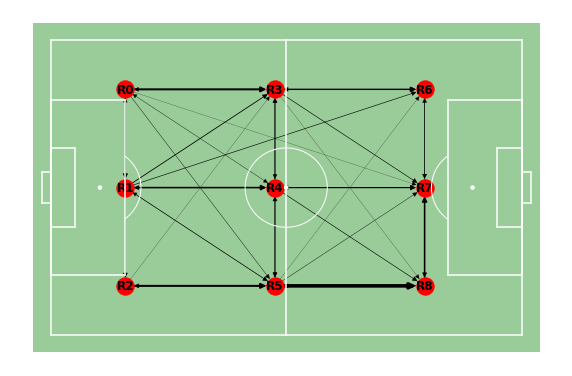

1609: mean = 2.3255813953488373 ; std = 2.3746158364347267 ; count = 140


In [173]:
matchId = 2499719

#Get the time for the latest event in the first half for this match
end_first_half = events.loc[(events['matchId']==matchId)
                            &(events['matchPeriod']=='1H'), ['eventSec']].max().values[0]


df = zonal_info_passing.loc[(zonal_info_passing.index.get_level_values(0)==matchId)]
df.loc[:, 'time'] = (df['matchPeriod']=='2H')*end_first_half + df['eventSec']
df['teamId'] = df.index.get_level_values(1)
#df = df[['playerId', 'positions', 'teamId', 'time']]


team1, team2 = df['teamId'].unique()
profile_team2 = df.loc[df['teamId'] == team2, :].sort_values(by='time').reset_index(drop=True)
profile_team2 = profile_team2[['zone_origin', 'zone_destination']]
profile_team2 = profile_team2.loc[profile_team2['zone_origin'] != profile_team2['zone_destination']]
profile_team2 = profile_team2.groupby(['zone_origin','zone_destination']).size().to_frame('weight').reset_index().astype(int)
#team2
ax = matplotsoccer.field("green",figsize=10, show=False)
g = nx.DiGraph()
g.add_edges_from([(row['zone_origin'], row['zone_destination'], {'weight':row['weight']}) for i, row in profile_team2.iterrows()])
g = nx.relabel_nodes(g, {i: 'R{}'.format(i) for i in range(9)})
nx.draw(g, zone_positions, with_labels=True, font_weight='bold', node_color = 'r',
        width=[g[u][v]['weight']/5 for u, v in g.edges()], ax=ax)
print ('\n\n\n', team2)
print ('centrality =', nx.global_reaching_centrality(g))
#print ('algebric connectivity =', nx.algebraic_connectivity(g))
print ('density =', nx.density(g))
plt.show()
print ('%s: mean ='%team1, profile_team2['weight'].mean()/profile_team2['weight'].sum()*100,
       '; std =', profile_team2['weight'].std()/profile_team2['weight'].sum()*100,
       '; count =', profile_team2['weight'].sum())

Text(0, 0.5, 'Relative Strength')

<Figure size 432x288 with 0 Axes>

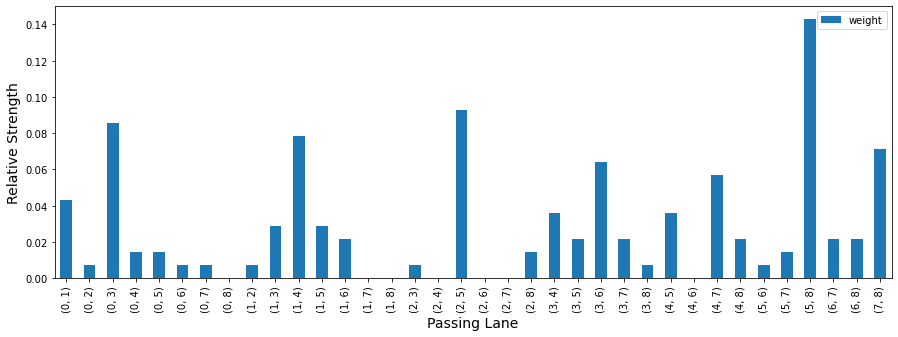

In [214]:
profile_team2['p1'] = profile_team2[['zone_origin', 'zone_destination']].min(axis=1)
profile_team2['p2'] = profile_team2[['zone_origin', 'zone_destination']].max(axis=1)
idx = pd.MultiIndex.from_tuples([(i, j) for i in range(9) for j in range(9) if i < j])
plt.figure()
(profile_team2[['p1', 'p2', 'weight']].groupby(by=['p1', 'p2']).sum()/profile_team2[['weight']].sum()).reindex(idx).plot(kind='bar', figsize=(15, 5))
plt.xlabel('Passing Lane', fontsize=14)
plt.ylabel('Relative Strength', fontsize=14)

A plot like this can tell us the relative strength of certain passing lanes.   
**Question**: Do teams show the same prominent passing lanes across all matches?  
**To-do**: Streamline this for all teams, all games

##### Streamlining

In [239]:
n = len(matches)
idx = pd.MultiIndex.from_tuples([(i, j) for i in range(9) for j in range(9) if i < j])
passing_lane_stats = dict()

for i, matchId in enumerate(matches):
    profile_team1, profile_team2 = None, None
    
    if i % 50 == 0: print('{}/{}'.format(i, n))
        
    #Get the time for the latest event in the first half for this match
    end_first_half = events.loc[(events['matchId']==matchId)
                                &(events['matchPeriod']=='1H'), ['eventSec']].max().values[0]


    df = zonal_info_passing.loc[(zonal_info_passing.index.get_level_values(0)==matchId)]
    df.loc[:, 'time'] = (df['matchPeriod']=='2H')*end_first_half + df['eventSec']
    df['teamId'] = df.index.get_level_values(1)
    #df = df[['playerId', 'positions', 'teamId', 'time']]


    team1, team2 = df['teamId'].unique()
    profile_team1 = df.loc[df['teamId'] == team1, :].sort_values(by='time').reset_index(drop=True)
    profile_team2 = df.loc[df['teamId'] == team2, :].sort_values(by='time').reset_index(drop=True)
    
    #Identifying passing lanes
    profile_team1 = profile_team1[['zone_origin', 'zone_destination']]
    profile_team1 = profile_team1.loc[profile_team1['zone_origin'] != profile_team1['zone_destination']]
    profile_team1 = profile_team1.groupby(['zone_origin','zone_destination']).size().to_frame('weight').reset_index().astype(int)
    profile_team1['p1'] = profile_team1[['zone_origin', 'zone_destination']].min(axis=1)
    profile_team1['p2'] = profile_team1[['zone_origin', 'zone_destination']].max(axis=1)    
    profile_team1 = profile_team1[['p1', 'p2', 'weight']]
    profile_team1 = profile_team1[['p1', 'p2', 'weight']].groupby(by=['p1', 'p2']).sum()/profile_team1[['weight']].sum()
    
    profile_team2 = profile_team2[['zone_origin', 'zone_destination']]
    profile_team2 = profile_team2.loc[profile_team2['zone_origin'] != profile_team2['zone_destination']]
    profile_team2 = profile_team2.groupby(['zone_origin','zone_destination']).size().to_frame('weight').reset_index().astype(int)
    profile_team2['p1'] = profile_team2[['zone_origin', 'zone_destination']].min(axis=1)
    profile_team2['p2'] = profile_team2[['zone_origin', 'zone_destination']].max(axis=1)    
    profile_team2 = profile_team2[['p1', 'p2', 'weight']]
    profile_team2 = profile_team2[['p1', 'p2', 'weight']].groupby(by=['p1', 'p2']).sum()/profile_team2[['weight']].sum()
    
    
    #Saving Stats
    passing_lane_stats[matchId] = dict()
    passing_lane_stats[matchId][team1], passing_lane_stats[matchId][team2] = dict(), dict()
    passing_lane_stats[matchId][team1] = profile_team1
    passing_lane_stats[matchId][team2] = profile_team2

    
    #make directories
    if not os.path.exists(os.path.join(ROOT, 'figures', 'passing_lane_study_nov_13', 'lane_distributions', str(team1))):
        os.makedirs(os.path.join(ROOT, 'figures', 'passing_lane_study_nov_13', 'lane_distributions', str(team1)))
        
    if not os.path.exists(os.path.join(ROOT, 'figures', 'passing_lane_study_nov_13', 'lane_distributions', str(team2))):
        os.makedirs(os.path.join(ROOT, 'figures', 'passing_lane_study_nov_13', 'lane_distributions', str(team2)))
    
    #Plotting & Saving
    plt.figure()
    profile_team1.reindex(idx).plot(kind='bar', figsize=(15, 5))
    plt.xlabel('Passing Lane', fontsize=12)
    plt.ylabel('Relative Strength', fontsize=12)
    plt.title('Match: {} | Team: {}'.format(matchId, team1))
    plt.savefig(os.path.join(ROOT, 'figures', 'passing_lane_study_nov_13', 'lane_distributions', str(team1), '{}.png'.format(matchId)))
    plt.close()
    
    plt.figure()
    profile_team2.reindex(idx).plot(kind='bar', figsize=(15, 5))
    plt.xlabel('Passing Lane', fontsize=12)
    plt.ylabel('Relative Strength', fontsize=12)
    plt.title('Match: {} | Team: {}'.format(matchId, team2))
    plt.savefig(os.path.join(ROOT, 'figures', 'passing_lane_study_nov_13', 'lane_distributions', str(team2), '{}.png'.format(matchId)))
    plt.close('all')
    

0/1826
50/1826
100/1826
150/1826
200/1826
250/1826
300/1826
350/1826
400/1826
450/1826
500/1826
550/1826
600/1826
650/1826
700/1826
750/1826
800/1826
850/1826
900/1826
950/1826
1000/1826
1050/1826
1100/1826
1150/1826
1200/1826
1250/1826
1300/1826
1350/1826
1400/1826
1450/1826
1500/1826
1550/1826
1600/1826
1650/1826
1700/1826
1750/1826
1800/1826


In [253]:
d = dict()
for k in passing_lane_stats:
    d[k]=pd.concat(passing_lane_stats[k])
    
d = pd.concat(d)
d

weight
             p1 p2          
2499719 1609 0  1   0.062189
                2   0.009950
                3   0.057214
                4   0.012438
                5   0.004975
...                      ...
2576338 3193 5  7   0.017361
                8   0.034722
             6  7   0.118056
                8   0.020833
             7  8   0.065972

[106406 rows x 1 columns]

In [254]:
d.to_pickle(os.path.join(ROOT, 'intermediates', 'zone_lane_info.pkl.gz'))

In [53]:
d = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'zone_lane_info.pkl.gz'))
d = d.unstack(level=['p1', 'p2']).droplevel(0, axis=1)
d.index = d.index.rename(['matchId', 'teamId'])
d.columns = d.columns.rename(['OriginZone', 'DestinationZone'])
d

OriginZone              0                                                    \
DestinationZone         1         2         3         4         5         6   
matchId teamId                                                                
2499719 1609     0.062189  0.009950  0.057214  0.012438  0.004975  0.004975   
        1631     0.042857  0.007143  0.085714  0.014286  0.014286  0.007143   
2499720 1625     0.017094  0.014957  0.021368  0.008547  0.004274       NaN   
        1651     0.067797  0.008475  0.093220  0.016949       NaN  0.016949   
2499721 1610     0.070796  0.023599  0.056047  0.038348  0.008850       NaN   
...                   ...       ...       ...       ...       ...       ...   
2576336 3315     0.042553  0.005319  0.063830  0.015957       NaN  0.005319   
2576337 3164     0.056140  0.003509  0.059649  0.003509  0.003509  0.007018   
        3204     0.046632       NaN  0.046632  0.005181       NaN  0.015544   
2576338 3185     0.140704  0.010050  0.090452       NaN       NaN  0.010050   
        3193     0.059028       NaN  0.038194  0.010417       NaN  0.003472   

OriginZone              1                                ...         6  \
DestinationZone         2         3         4         5  ...         7   
matchId teamId                                           ...             
2499719 1609     0.029851  0.017413  0.034826  0.029851  ...  0.044776   
        1631     0.007143  0.028571  0.078571  0.028571  ...  0.021429   
2499720 1625     0.019231  0.010684  0.027778  0.019231  ...  0.055556   
        1651     0.084746  0.050847  0.042373  0.067797  ...  0.008475   
2499721 1610     0.061947  0.026549  0.047198  0.023599  ...  0.091445   
...                   ...       ...       ...       ...  ...       ...   
2576336 3315     0.106383  0.026596  0.021277  0.069149  ...  0.074468   
2576337 3164     0.063158  0.031579  0.066667  0.031579  ...  0.045614   
        3204     0.082902  0.067358  0.025907  0.031088  ...  0.056995   
2576338 3185     0.105528  0.040201  0.015075  0.030151  ...  0.050251   
        3193     0.031250  0.024306  0.052083  0.034722  ...  0.118056   

OriginZone                        7         0         2         1         2  \
DestinationZone         8         8         7         3         8         6   
matchId teamId                                                                
2499719 1609     0.007463  0.069652       NaN       NaN       NaN       NaN   
        1631     0.021429  0.071429  0.007143  0.007143       NaN       NaN   
2499720 1625     0.012821  0.034188       NaN  0.006410       NaN       NaN   
        1651          NaN  0.016949  0.008475       NaN  0.008475  0.008475   
2499721 1610     0.014749  0.053097  0.002950  0.008850  0.005900       NaN   
...                   ...       ...       ...       ...       ...       ...   
2576336 3315     0.037234  0.058511       NaN  0.010638  0.005319  0.005319   
2576337 3164     0.007018  0.035088       NaN  0.003509       NaN       NaN   
        3204     0.015544  0.036269  0.005181  0.010363  0.005181  0.005181   
2576338 3185     0.005025  0.045226  0.005025  0.005025       NaN  0.005025   
        3193     0.020833  0.065972       NaN       NaN       NaN       NaN   

OriginZone             0         1         2  
DestinationZone        8         7         7  
matchId teamId                                
2499719 1609         NaN       NaN       NaN  
        1631         NaN       NaN       NaN  
2499720 1625         NaN       NaN       NaN  
        1651         NaN       NaN       NaN  
2499721 1610     0.00295  0.011799       NaN  
...                  ...       ...       ...  
2576336 3315         NaN  0.005319  0.005319  
2576337 3164         NaN       NaN       NaN  
        3204         NaN       NaN  0.005181  
2576338 3185         NaN  0.010050       NaN  
        3193         NaN       NaN       NaN  

[3652 rows x 36 columns]

These are 36 more features for each team, each match

### Zonal Graph Performance

In [48]:
df = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'player_passing_networks_exploration.pkl.gz'))
df2 = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'zonal_passing_networks_exploration.pkl.gz'))
performance = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'team_performance.pkl.gz'))
df.index = df.index.rename(['matchId', 'teamId'])

df = pd.concat([df, df2], axis=1)
display(df)

df.iloc[:, 1:] = df.iloc[:, 1:].divide(df['w'],axis=0)

df = df.mean(level=1).sort_index()
df = pd.concat([df, performance], axis=1)

w  mean_passes_players  std_passes_players  \
matchId teamId                                                   
2499719 1609    606.0            84.285714           59.311989   
        1631    230.0            30.285714           16.559583   
2499720 1625    754.0           105.428571           73.886310   
        1651    184.0            24.428571           14.345808   
2499721 1610    516.0            77.230769           48.071395   
...               ...                  ...                 ...   
2576336 3315    337.0            46.571429           24.453140   
2576337 3164    446.0            66.615385           39.434626   
        3204    363.0            53.538462           23.564151   
2576338 3185    338.0            46.571429           18.756391   
        3193    532.0            73.714286           35.497407   

                mean_passes_zone  std_passes_zone  
matchId teamId                                     
2499719 1609           89.333333        34.939233  
        1631           31.111111        10.178954  
2499720 1625          104.000000        67.673850  
        1651           26.222222        10.883218  
2499721 1610           75.333333        20.850659  
...                          ...              ...  
2576336 3315           41.777778         8.728943  
2576337 3164           63.333333        27.399818  
        3204           42.888889        16.914819  
2576338 3185           44.222222        14.584048  
        3193           64.000000        29.176189  

[3652 rows x 5 columns]

In [38]:
df

,w,mean_passes_players,std_passes_players,mean_passes_zone,std_passes_zone,name,city,area.name,avg_pass_per_game,avg_shots_per_game,avg_goals_per_game,end_of_season_pts
674,413.789474,0.140712,0.088340,0.137419,0.054103,Valencia,Valencia,Spain,413.789474,11.000000,1.421053,73
675,581.078947,0.142033,0.078846,0.128619,0.045808,Real Madrid,Madrid,Spain,581.078947,16.605263,2.131579,76
676,612.105263,0.140638,0.078046,0.130913,0.054780,Barcelona,Barcelona,Spain,612.105263,13.210526,2.289474,93
677,382.605263,0.139624,0.076254,0.130934,0.044505,Deportivo La Coru\u00f1a,A Coru\u00f1a,Spain,382.605263,10.657895,0.921053,29
678,395.315789,0.140148,0.075199,0.138273,0.053388,Athletic Club,Bilbao,Spain,395.315789,9.921053,0.842105,43
...,...,...,...,...,...,...,...,...,...,...,...,...
3795,360.605263,0.137623,0.075303,0.127538,0.042832,Troyes,Troyes,France,360.605263,8.578947,0.710526,33
3799,379.105263,0.139537,0.080479,0.128009,0.048654,Angers,Angers,France,379.105263,10.736842,0.947368,43
3804,390.131579,0.139629,0.076787,0.136396,0.049637,Dijon,Dijon,France,390.131579,10.368421,1.236842,46
10531,390.578947,0.139775,0.079595,0.134895,0.053079,Swansea City,Swansea,England,390.578947,8.000000,0.684211,33


<Figure size 1080x360 with 0 Axes>

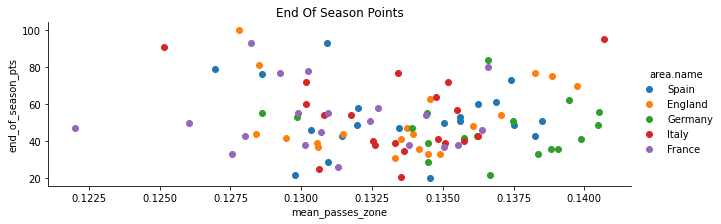

<Figure size 1080x360 with 0 Axes>

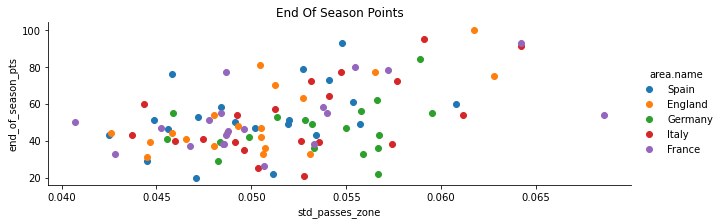

In [46]:
import seaborn
from matplotlib import pyplot 
#from ggplot import *

plt.figure(figsize=(15, 5))
fg = seaborn.FacetGrid(data=df, hue='area.name', hue_order=df['area.name'].unique(), aspect=3)
fg.map(pyplot.scatter, 'mean_passes_zone', 'end_of_season_pts').add_legend()
plt.title('End Of Season Points')
plt.savefig('../figures/9_zone_network/mean_vs_avg_goals_norm.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(15, 5))
fg = seaborn.FacetGrid(data=df, hue='area.name', hue_order=df['area.name'].unique(), aspect=3)
fg.map(pyplot.scatter, 'std_passes_zone', 'end_of_season_pts').add_legend()
plt.title('End Of Season Points')
plt.savefig('../figures/9_zone_network/std_vs_avg_goals_norm.png', bbox_inches='tight')
plt.show()

,w,mean_passes_players,std_passes_players,mean_passes_zone,std_passes_zone,avg_pass_per_game,avg_shots_per_game,avg_goals_per_game,end_of_season_pts
w,1.000000,0.217785,0.589938,-0.140192,0.638778,1.000000,0.803065,0.812468,0.763279
mean_passes_players,0.217785,1.000000,0.117718,0.003642,0.223724,0.217785,0.153953,0.187259,0.186572
std_passes_players,0.589938,0.117718,1.000000,0.034503,0.542965,0.589938,0.434198,0.427707,0.502012
mean_passes_zone,-0.140192,0.003642,0.034503,1.000000,0.232734,-0.140192,-0.068123,-0.048375,-0.086291
std_passes_zone,0.638778,0.223724,0.542965,0.232734,1.000000,0.638778,0.343656,0.500133,0.470776
avg_pass_per_game,1.000000,0.217785,0.589938,-0.140192,0.638778,1.000000,0.803065,0.812468,0.763279
avg_shots_per_game,0.803065,0.153953,0.434198,-0.068123,0.343656,0.803065,1.000000,0.774971,0.719890
avg_goals_per_game,0.812468,0.187259,0.427707,-0.048375,0.500133,0.812468,0.774971,1.000000,0.873299
end_of_season_pts,0.763279,0.186572,0.502012,-0.086291,0.470776,0.763279,0.719890,0.873299,1.000000
